# Actor Critic

In [1]:
# Set relative path to parent directory
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
# Import environment
from environments.pendulum import pendulum

env = pendulum(mass=1, length=1, gravity=9.81)
env.step_size = 0.05

# Define reward function

angle_normalize =  lambda x: ((x+np.pi) % (2*np.pi)) - np.pi
env.reward = lambda : -angle_normalize(env.x[0])**2 - .1*env.x[1]**2

# Define terminal state
env.terminal = lambda : np.abs(env.x[0]) > 3*np.pi

# Define state variabels
env.state = lambda : np.array([np.cos(env.x[0]), np.sin(env.x[0]), env.x[1]])

In [3]:
import tensorflow.contrib.slim as slim
import tensorflow as tf
import numpy as np
import gym

## Actor class
The following codes sets up the neural network for the actor. The actor has two functions, the choose_action and learn functions.

### The Network
The Actor network consists of some hidden layers which learns the abstraction of the inpuut action. This then feeds into two layers which learn the standard deviation $\sigma$, and the mean $\mu$ of the normaldistribution (see the image below), which decides which action to take. 
<img src="https://upload.wikimedia.org/wikipedia/commons/7/74/Normal_Distribution_PDF.svg" alt="Drawing" style="width: 300px;"/>

### Choosing an action
The action to take is chosen by feeding a state into the network, and predicting the resulting standard deviation $\sigma$ and mean $\mu$. A random action based on the distribution is then chosen.

### Learning
The learning alorithem works by finding the probability of the action taken given the distribution. $P(a)$, it then computes the log probability and multiplies this with the temporal diference error, which guides the gradient decent in the direction which will give a better value then the current policy, and away from areas which give a worse value then with the current policy.

In [4]:
class Actor(object):
    def __init__(self, sess, n_features, n_actions, action_bound, hidden_layer_shape = [32], lr=1e-4, min_variance = 0.1):
        self.sess = sess
        self.action_offset = (action_bound[1] + action_bound[0])/2
        self.action_scale = (action_bound[1] - action_bound[0])/2
        self.min_variance = min_variance
        
        # Placeholders for action and td_error for learning, and state for learning and action selection
        self.state = tf.placeholder(tf.float32, [None, n_features], "state")
        self.action_holder = tf.placeholder(tf.float32, None, name="action")
        self.td_error = tf.placeholder(tf.float32, None, name="td_error")  # TD_error
        
        # Actor hidden layers
        hidden = slim.stack(inputs = self.state,
                            layer = slim.fully_connected, 
                            stack_args = hidden_layer_shape,
                            activation_fn = tf.nn.relu, 
                            weights_initializer = tf.random_normal_initializer(0., .1),  # weights
                            biases_initializer = tf.constant_initializer(0.1),  # biases
                            scope='hidden')
        
        # Predicted mean
        mu = tf.layers.dense(
            inputs=hidden,
            units=n_actions,
            activation=tf.nn.tanh,
            kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
            bias_initializer=tf.constant_initializer(0.1),  # biases
            name='mu'
        )
        
        # Predicted standard deviation
        sigma = tf.layers.dense(
            inputs=hidden,
            units=n_actions,
            activation=tf.nn.softplus,  # get action probabilities
            kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
            bias_initializer=tf.constant_initializer(1.),  # biases
            name='sigma'
        )
        # Decaying learning rate (include global step in optimizer)
            #global_step = tf.Variable(0, trainable=False)
            # self.e = epsilon = tf.train.exponential_decay(2., global_step, 1000, 0.9)
            
        # Scale mu to fill action space, and add minimum varaince to sigma
        self.mu = mu*self.action_scale + self.action_offset
        self.sigma = sigma + self.min_variance
        
        # Create normal distribution based on sigma and mu
        self.normal_dist = tf.distributions.Normal(self.mu, self.sigma)

        # Draw action from normal distribution given sigma and mu
        self.action = tf.clip_by_value(self.normal_dist.sample(1), action_bound[0], action_bound[1])[0]

        with tf.name_scope('exp_v'):
            log_prob = self.normal_dist.log_prob(self.action_holder)  # loss without advantage
            self.exp_v = log_prob * self.td_error  # advantage (TD_error) guided loss
            # Add cross entropy cost to encourage exploration
            self.exp_v += 0.01*self.normal_dist.entropy()

        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(-self.exp_v)

    def learn(self, state, action, td_error, batch = False):
        if batch == False:
            state = state[np.newaxis, :]
        feed_dict = {self.state: state, self.action_holder: action, self.td_error: td_error}
        _, exp_v = self.sess.run([self.train_op, self.exp_v], feed_dict)
        return exp_v

    def choose_action(self, state, batch = False):
        if batch == False:
            state = state[np.newaxis, :]
        return self.sess.run(self.action, {self.state: state})  # get probabilities for all actions
    
    

## Critic class
The critic is responsible for estimating the value function of the policy the actor is following. It does so by using a neural network to parameterize the value function $V(s)$. To find the best parameterization of the value function the critic learns by updating the value function using the temporal difference error $r + \gamma V(s') - V(s)$ whith the loss function as the squared temporal difference error.

In [5]:
class Critic(object):
    def __init__(self, sess, n_features, hidden_layer_shape = [32, 64], lr=1e-3):
        self.sess = sess
        with tf.name_scope('inputs'):
            self.state = tf.placeholder(tf.float32, [None, n_features], "state")
            self.v_next = tf.placeholder(tf.float32, [None, 1], name="v_next")
            self.reward = tf.placeholder(tf.float32, None, name='reward')

        with tf.variable_scope('Critic'):
            hidden = slim.stack(inputs = self.state,
                                layer = slim.fully_connected, 
                                stack_args = hidden_layer_shape,
                                activation_fn = tf.nn.relu, 
                                weights_initializer = tf.random_normal_initializer(0., .1),  # weights
                                biases_initializer = tf.constant_initializer(0.1),  # biases
                                scope='hidden'
            )

            self.v = tf.layers.dense(
                inputs=hidden,
                units=1,
                activation=None,
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='value_function'
            )

        with tf.variable_scope('squared_TD_error'):
            self.td_error = self.reward + GAMMA * self.v_next - self.v 
            self.loss = tf.square(tf.reduce_mean(self.td_error))
        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)

    def learn(self, state, reward, state_next, batch = False):
        if batch == False:
            state = state[np.newaxis, :]
            state_next = state_next[np.newaxis, :]
        
        # Get value of next state
        v_next = self.sess.run(self.v, {self.state: state_next})
        
        # Gradient decent using td_error
        train_dict = {self.state: state, self.v_next: v_next, self.reward: reward}
        td_error, _ = self.sess.run([self.td_error, self.train_op], train_dict)
        return td_error

## Experience replay buffer
The idea behind the experience replay buffer is that by storing an agent’s experiences, and then randomly drawing batches of them to train the network, we can more robustly learn to perform well in the task. By keeping the experiences we draw random, we prevent the network from only learning about what it is immediately doing in the environment, and allow it to learn from a more varied array of past experiences. The experience is stored as a tuple $[s, a, r, s']$ where $s$ is the state we are in, $a$ is the action we take, $r$ is the reward we get, and $s'$ is the state we end up in. 

In [6]:
import random
class experience_buffer():
    def __init__(self, buffer_size = 1000000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [7]:
np.random.seed(2)
tf.set_random_seed(2)

# Reset graph
tf.reset_default_graph()

# Training parameters
MAX_EPISODE = 40000
MAX_EP_STEPS = 200
BATCH_SIZE = 32
GAMMA = 0.9
LR_A = 1e-4    # learning rate for actor
LR_C = 1e-3    # learning rate for critic

# create experience buffer
experience = experience_buffer()

# Save and show reward
running_reward = 0
reward_list = []

nx = len(env.state()) #number of states
nu = 1 #Number of inputs
a_max = 5

sess = tf.Session()

# Set up actor and critic
actor = Actor(sess, n_features=nx, n_actions=nu, lr=LR_A, action_bound=[-a_max, a_max])
critic = Critic(sess, n_features=nx, lr=LR_C)
sess.run(tf.global_variables_initializer())

In [17]:
for i_episode in range(MAX_EPISODE):
    theta =  (2*np.random.random() - 1)*np.pi
    theta_dot =  (2*np.random.random() - 1)*5
    s = env.init([theta,theta_dot])
    t = 1
    ep_rs = []
    while True:
        # Choose action (Actor)
        a = actor.choose_action(s)[0]
        
        # Perform action and observe reward and next state
        s_ = env.step(a)
        r = env.reward()
        done = env.terminal()
        
        # Save experience
        experience.add(np.reshape(np.array([s,a,np.array(r/10),s_,np.array(done)]),[1,5]))
        
        if t%BATCH_SIZE == 0:
            batch = experience.sample(BATCH_SIZE)
            b_s = np.vstack(batch[:,0])
            b_a = np.vstack(batch[:,1])
            b_r = np.vstack(batch[:,2])
            b_s_ = np.vstack(batch[:,3])
            
            # gradient = grad[r + gamma * V(s_) - V(s)]
            td_error = critic.learn(b_s, b_r, b_s_, batch=True)
            
            # Mask out negative experience in order to not train the actor on it
            mask = np.ndarray.flatten(td_error >= 0)
            
            # true_gradient = grad[logPi(s,a) * td_error]
            actor.learn(b_s[mask], b_a[mask], td_error[mask], batch=True)
            
            experience.buffer = []

        s = s_
        t += 1
        ep_rs.append(r)
        if t > MAX_EP_STEPS:
            running_reward = running_reward * 0.9 + sum(ep_rs) * 0.1 if running_reward != 0 else sum(ep_rs)
            reward_list.append(sum(ep_rs))
            print("episode:", i_episode, "  reward:", int(running_reward))
            break

episode: 0   reward: -584
episode: 1   reward: -661
episode: 2   reward: -609
episode: 3   reward: -670
episode: 4   reward: -705
episode: 5   reward: -747
episode: 6   reward: -686
episode: 7   reward: -646
episode: 8   reward: -668
episode: 9   reward: -603
episode: 10   reward: -674
episode: 11   reward: -716
episode: 12   reward: -742
episode: 13   reward: -764
episode: 14   reward: -716
episode: 15   reward: -648
episode: 16   reward: -710
episode: 17   reward: -683
episode: 18   reward: -735
episode: 19   reward: -676
episode: 20   reward: -609
episode: 21   reward: -549
episode: 22   reward: -497
episode: 23   reward: -479
episode: 24   reward: -539
episode: 25   reward: -497
episode: 26   reward: -536
episode: 27   reward: -496
episode: 28   reward: -475
episode: 29   reward: -544
episode: 30   reward: -505
episode: 31   reward: -594
episode: 32   reward: -549
episode: 33   reward: -631
episode: 34   reward: -667
episode: 35   reward: -684
episode: 36   reward: -754
episode: 37

episode: 298   reward: -623
episode: 299   reward: -696
episode: 300   reward: -712
episode: 301   reward: -756
episode: 302   reward: -799
episode: 303   reward: -836
episode: 304   reward: -879
episode: 305   reward: -792
episode: 306   reward: -724
episode: 307   reward: -745
episode: 308   reward: -692
episode: 309   reward: -734
episode: 310   reward: -795
episode: 311   reward: -729
episode: 312   reward: -657
episode: 313   reward: -681
episode: 314   reward: -615
episode: 315   reward: -655
episode: 316   reward: -727
episode: 317   reward: -766
episode: 318   reward: -692
episode: 319   reward: -638
episode: 320   reward: -673
episode: 321   reward: -607
episode: 322   reward: -648
episode: 323   reward: -686
episode: 324   reward: -647
episode: 325   reward: -684
episode: 326   reward: -633
episode: 327   reward: -587
episode: 328   reward: -544
episode: 329   reward: -614
episode: 330   reward: -553
episode: 331   reward: -514
episode: 332   reward: -478
episode: 333   rewar

episode: 591   reward: -536
episode: 592   reward: -508
episode: 593   reward: -540
episode: 594   reward: -623
episode: 595   reward: -581
episode: 596   reward: -541
episode: 597   reward: -503
episode: 598   reward: -467
episode: 599   reward: -523
episode: 600   reward: -500
episode: 601   reward: -465
episode: 602   reward: -549
episode: 603   reward: -618
episode: 604   reward: -650
episode: 605   reward: -597
episode: 606   reward: -555
episode: 607   reward: -507
episode: 608   reward: -472
episode: 609   reward: -440
episode: 610   reward: -537
episode: 611   reward: -498
episode: 612   reward: -478
episode: 613   reward: -548
episode: 614   reward: -580
episode: 615   reward: -527
episode: 616   reward: -489
episode: 617   reward: -452
episode: 618   reward: -520
episode: 619   reward: -481
episode: 620   reward: -448
episode: 621   reward: -433
episode: 622   reward: -401
episode: 623   reward: -472
episode: 624   reward: -450
episode: 625   reward: -510
episode: 626   rewar

episode: 884   reward: -412
episode: 885   reward: -400
episode: 886   reward: -370
episode: 887   reward: -390
episode: 888   reward: -353
episode: 889   reward: -347
episode: 890   reward: -326
episode: 891   reward: -424
episode: 892   reward: -393
episode: 893   reward: -370
episode: 894   reward: -362
episode: 895   reward: -349
episode: 896   reward: -343
episode: 897   reward: -324
episode: 898   reward: -337
episode: 899   reward: -434
episode: 900   reward: -405
episode: 901   reward: -388
episode: 902   reward: -376
episode: 903   reward: -339
episode: 904   reward: -331
episode: 905   reward: -384
episode: 906   reward: -448
episode: 907   reward: -418
episode: 908   reward: -377
episode: 909   reward: -358
episode: 910   reward: -352
episode: 911   reward: -433
episode: 912   reward: -412
episode: 913   reward: -402
episode: 914   reward: -391
episode: 915   reward: -364
episode: 916   reward: -357
episode: 917   reward: -336
episode: 918   reward: -318
episode: 919   rewar

episode: 1171   reward: -426
episode: 1172   reward: -398
episode: 1173   reward: -374
episode: 1174   reward: -475
episode: 1175   reward: -443
episode: 1176   reward: -399
episode: 1177   reward: -388
episode: 1178   reward: -378
episode: 1179   reward: -444
episode: 1180   reward: -425
episode: 1181   reward: -427
episode: 1182   reward: -490
episode: 1183   reward: -564
episode: 1184   reward: -624
episode: 1185   reward: -577
episode: 1186   reward: -635
episode: 1187   reward: -604
episode: 1188   reward: -661
episode: 1189   reward: -606
episode: 1190   reward: -646
episode: 1191   reward: -596
episode: 1192   reward: -552
episode: 1193   reward: -630
episode: 1194   reward: -585
episode: 1195   reward: -540
episode: 1196   reward: -623
episode: 1197   reward: -563
episode: 1198   reward: -641
episode: 1199   reward: -691
episode: 1200   reward: -636
episode: 1201   reward: -679
episode: 1202   reward: -623
episode: 1203   reward: -664
episode: 1204   reward: -626
episode: 1205 

episode: 1454   reward: -713
episode: 1455   reward: -656
episode: 1456   reward: -605
episode: 1457   reward: -559
episode: 1458   reward: -632
episode: 1459   reward: -671
episode: 1460   reward: -628
episode: 1461   reward: -643
episode: 1462   reward: -579
episode: 1463   reward: -640
episode: 1464   reward: -602
episode: 1465   reward: -553
episode: 1466   reward: -513
episode: 1467   reward: -462
episode: 1468   reward: -441
episode: 1469   reward: -415
episode: 1470   reward: -492
episode: 1471   reward: -553
episode: 1472   reward: -583
episode: 1473   reward: -571
episode: 1474   reward: -541
episode: 1475   reward: -517
episode: 1476   reward: -482
episode: 1477   reward: -447
episode: 1478   reward: -490
episode: 1479   reward: -568
episode: 1480   reward: -526
episode: 1481   reward: -487
episode: 1482   reward: -578
episode: 1483   reward: -534
episode: 1484   reward: -509
episode: 1485   reward: -473
episode: 1486   reward: -445
episode: 1487   reward: -415
episode: 1488 

episode: 1737   reward: -583
episode: 1738   reward: -542
episode: 1739   reward: -571
episode: 1740   reward: -515
episode: 1741   reward: -597
episode: 1742   reward: -664
episode: 1743   reward: -613
episode: 1744   reward: -670
episode: 1745   reward: -726
episode: 1746   reward: -775
episode: 1747   reward: -713
episode: 1748   reward: -642
episode: 1749   reward: -711
episode: 1750   reward: -668
episode: 1751   reward: -718
episode: 1752   reward: -673
episode: 1753   reward: -619
episode: 1754   reward: -579
episode: 1755   reward: -623
episode: 1756   reward: -592
episode: 1757   reward: -547
episode: 1758   reward: -599
episode: 1759   reward: -673
episode: 1760   reward: -729
episode: 1761   reward: -766
episode: 1762   reward: -791
episode: 1763   reward: -741
episode: 1764   reward: -760
episode: 1765   reward: -714
episode: 1766   reward: -644
episode: 1767   reward: -592
episode: 1768   reward: -671
episode: 1769   reward: -607
episode: 1770   reward: -575
episode: 1771 

episode: 2020   reward: -521
episode: 2021   reward: -555
episode: 2022   reward: -590
episode: 2023   reward: -561
episode: 2024   reward: -520
episode: 2025   reward: -479
episode: 2026   reward: -448
episode: 2027   reward: -515
episode: 2028   reward: -578
episode: 2029   reward: -535
episode: 2030   reward: -509
episode: 2031   reward: -458
episode: 2032   reward: -428
episode: 2033   reward: -401
episode: 2034   reward: -422
episode: 2035   reward: -394
episode: 2036   reward: -461
episode: 2037   reward: -547
episode: 2038   reward: -522
episode: 2039   reward: -482
episode: 2040   reward: -453
episode: 2041   reward: -423
episode: 2042   reward: -468
episode: 2043   reward: -436
episode: 2044   reward: -410
episode: 2045   reward: -474
episode: 2046   reward: -509
episode: 2047   reward: -486
episode: 2048   reward: -449
episode: 2049   reward: -432
episode: 2050   reward: -420
episode: 2051   reward: -382
episode: 2052   reward: -359
episode: 2053   reward: -368
episode: 2054 

episode: 2303   reward: -630
episode: 2304   reward: -568
episode: 2305   reward: -526
episode: 2306   reward: -504
episode: 2307   reward: -467
episode: 2308   reward: -536
episode: 2309   reward: -499
episode: 2310   reward: -546
episode: 2311   reward: -590
episode: 2312   reward: -655
episode: 2313   reward: -716
episode: 2314   reward: -732
episode: 2315   reward: -675
episode: 2316   reward: -637
episode: 2317   reward: -591
episode: 2318   reward: -547
episode: 2319   reward: -594
episode: 2320   reward: -628
episode: 2321   reward: -660
episode: 2322   reward: -694
episode: 2323   reward: -743
episode: 2324   reward: -774
episode: 2325   reward: -832
episode: 2326   reward: -764
episode: 2327   reward: -702
episode: 2328   reward: -755
episode: 2329   reward: -682
episode: 2330   reward: -714
episode: 2331   reward: -732
episode: 2332   reward: -674
episode: 2333   reward: -637
episode: 2334   reward: -605
episode: 2335   reward: -558
episode: 2336   reward: -591
episode: 2337 

episode: 2586   reward: -483
episode: 2587   reward: -453
episode: 2588   reward: -421
episode: 2589   reward: -402
episode: 2590   reward: -379
episode: 2591   reward: -343
episode: 2592   reward: -324
episode: 2593   reward: -405
episode: 2594   reward: -381
episode: 2595   reward: -455
episode: 2596   reward: -425
episode: 2597   reward: -398
episode: 2598   reward: -460
episode: 2599   reward: -430
episode: 2600   reward: -407
episode: 2601   reward: -506
episode: 2602   reward: -455
episode: 2603   reward: -411
episode: 2604   reward: -397
episode: 2605   reward: -480
episode: 2606   reward: -445
episode: 2607   reward: -410
episode: 2608   reward: -381
episode: 2609   reward: -365
episode: 2610   reward: -357
episode: 2611   reward: -391
episode: 2612   reward: -367
episode: 2613   reward: -362
episode: 2614   reward: -354
episode: 2615   reward: -321
episode: 2616   reward: -399
episode: 2617   reward: -377
episode: 2618   reward: -355
episode: 2619   reward: -454
episode: 2620 

episode: 2869   reward: -419
episode: 2870   reward: -403
episode: 2871   reward: -464
episode: 2872   reward: -446
episode: 2873   reward: -430
episode: 2874   reward: -424
episode: 2875   reward: -410
episode: 2876   reward: -386
episode: 2877   reward: -364
episode: 2878   reward: -328
episode: 2879   reward: -400
episode: 2880   reward: -361
episode: 2881   reward: -327
episode: 2882   reward: -300
episode: 2883   reward: -298
episode: 2884   reward: -406
episode: 2885   reward: -382
episode: 2886   reward: -373
episode: 2887   reward: -473
episode: 2888   reward: -441
episode: 2889   reward: -514
episode: 2890   reward: -602
episode: 2891   reward: -570
episode: 2892   reward: -530
episode: 2893   reward: -505
episode: 2894   reward: -472
episode: 2895   reward: -540
episode: 2896   reward: -609
episode: 2897   reward: -571
episode: 2898   reward: -526
episode: 2899   reward: -571
episode: 2900   reward: -540
episode: 2901   reward: -541
episode: 2902   reward: -504
episode: 2903 

episode: 3153   reward: -578
episode: 3154   reward: -541
episode: 3155   reward: -501
episode: 3156   reward: -463
episode: 3157   reward: -483
episode: 3158   reward: -548
episode: 3159   reward: -511
episode: 3160   reward: -489
episode: 3161   reward: -580
episode: 3162   reward: -656
episode: 3163   reward: -639
episode: 3164   reward: -715
episode: 3165   reward: -673
episode: 3166   reward: -691
episode: 3167   reward: -740
episode: 3168   reward: -681
episode: 3169   reward: -629
episode: 3170   reward: -651
episode: 3171   reward: -686
episode: 3172   reward: -730
episode: 3173   reward: -769
episode: 3174   reward: -707
episode: 3175   reward: -723
episode: 3176   reward: -769
episode: 3177   reward: -695
episode: 3178   reward: -717
episode: 3179   reward: -660
episode: 3180   reward: -633
episode: 3181   reward: -695
episode: 3182   reward: -638
episode: 3183   reward: -603
episode: 3184   reward: -677
episode: 3185   reward: -719
episode: 3186   reward: -732
episode: 3187 

episode: 3437   reward: -312
episode: 3438   reward: -296
episode: 3439   reward: -365
episode: 3440   reward: -465
episode: 3441   reward: -429
episode: 3442   reward: -404
episode: 3443   reward: -366
episode: 3444   reward: -452
episode: 3445   reward: -415
episode: 3446   reward: -395
episode: 3447   reward: -383
episode: 3448   reward: -459
episode: 3449   reward: -455
episode: 3450   reward: -424
episode: 3451   reward: -383
episode: 3452   reward: -348
episode: 3453   reward: -327
episode: 3454   reward: -318
episode: 3455   reward: -371
episode: 3456   reward: -334
episode: 3457   reward: -302
episode: 3458   reward: -301
episode: 3459   reward: -378
episode: 3460   reward: -342
episode: 3461   reward: -336
episode: 3462   reward: -314
episode: 3463   reward: -300
episode: 3464   reward: -289
episode: 3465   reward: -373
episode: 3466   reward: -362
episode: 3467   reward: -340
episode: 3468   reward: -321
episode: 3469   reward: -304
episode: 3470   reward: -401
episode: 3471 

C:\Users\andreabm\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 3579   reward: -365
episode: 3580   reward: -345
episode: 3581   reward: -350
episode: 3582   reward: -406
episode: 3583   reward: -367
episode: 3584   reward: -345
episode: 3585   reward: -417
episode: 3586   reward: -492
episode: 3587   reward: -472
episode: 3588   reward: -533
episode: 3589   reward: -492
episode: 3590   reward: -471
episode: 3591   reward: -450
episode: 3592   reward: -425
episode: 3593   reward: -469
episode: 3594   reward: -438
episode: 3595   reward: -422
episode: 3596   reward: -499
episode: 3597   reward: -466
episode: 3598   reward: -422
episode: 3599   reward: -395
episode: 3600   reward: -375
episode: 3601   reward: -368
episode: 3602   reward: -333
episode: 3603   reward: -319
episode: 3604   reward: -331
episode: 3605   reward: -327
episode: 3606   reward: -305
episode: 3607   reward: -303
episode: 3608   reward: -381
episode: 3609   reward: -449
episode: 3610   reward: -405
episode: 3611   reward: -381
episode: 3612   reward: -354
episode: 3613   reward

episode: 3863   reward: -388
episode: 3864   reward: -350
episode: 3865   reward: -317
episode: 3866   reward: -287
episode: 3867   reward: -274
episode: 3868   reward: -276
episode: 3869   reward: -250
episode: 3870   reward: -227
episode: 3871   reward: -303
episode: 3872   reward: -288
episode: 3873   reward: -266
episode: 3874   reward: -253
episode: 3875   reward: -272
episode: 3876   reward: -259
episode: 3877   reward: -261
episode: 3878   reward: -330
episode: 3879   reward: -312
episode: 3880   reward: -383
episode: 3881   reward: -370
episode: 3882   reward: -343
episode: 3883   reward: -382
episode: 3884   reward: -368
episode: 3885   reward: -340
episode: 3886   reward: -327
episode: 3887   reward: -415
episode: 3888   reward: -389
episode: 3889   reward: -483
episode: 3890   reward: -450
episode: 3891   reward: -419
episode: 3892   reward: -416
episode: 3893   reward: -502
episode: 3894   reward: -477
episode: 3895   reward: -440
episode: 3896   reward: -411
episode: 3897 

episode: 4146   reward: -748
episode: 4147   reward: -754
episode: 4148   reward: -693
episode: 4149   reward: -633
episode: 4150   reward: -706
episode: 4151   reward: -650
episode: 4152   reward: -595
episode: 4153   reward: -547
episode: 4154   reward: -522
episode: 4155   reward: -482
episode: 4156   reward: -448
episode: 4157   reward: -512
episode: 4158   reward: -474
episode: 4159   reward: -449
episode: 4160   reward: -416
episode: 4161   reward: -484
episode: 4162   reward: -462
episode: 4163   reward: -433
episode: 4164   reward: -392
episode: 4165   reward: -367
episode: 4166   reward: -332
episode: 4167   reward: -378
episode: 4168   reward: -355
episode: 4169   reward: -334
episode: 4170   reward: -416
episode: 4171   reward: -389
episode: 4172   reward: -366
episode: 4173   reward: -338
episode: 4174   reward: -438
episode: 4175   reward: -502
episode: 4176   reward: -463
episode: 4177   reward: -524
episode: 4178   reward: -486
episode: 4179   reward: -559
episode: 4180 

episode: 4429   reward: -542
episode: 4430   reward: -489
episode: 4431   reward: -549
episode: 4432   reward: -496
episode: 4433   reward: -457
episode: 4434   reward: -442
episode: 4435   reward: -536
episode: 4436   reward: -510
episode: 4437   reward: -536
episode: 4438   reward: -540
episode: 4439   reward: -539
episode: 4440   reward: -514
episode: 4441   reward: -489
episode: 4442   reward: -452
episode: 4443   reward: -410
episode: 4444   reward: -478
episode: 4445   reward: -526
episode: 4446   reward: -585
episode: 4447   reward: -554
episode: 4448   reward: -499
episode: 4449   reward: -450
episode: 4450   reward: -415
episode: 4451   reward: -501
episode: 4452   reward: -587
episode: 4453   reward: -545
episode: 4454   reward: -570
episode: 4455   reward: -535
episode: 4456   reward: -616
episode: 4457   reward: -582
episode: 4458   reward: -640
episode: 4459   reward: -591
episode: 4460   reward: -545
episode: 4461   reward: -507
episode: 4462   reward: -551
episode: 4463 

episode: 4713   reward: -666
episode: 4714   reward: -644
episode: 4715   reward: -601
episode: 4716   reward: -568
episode: 4717   reward: -549
episode: 4718   reward: -509
episode: 4719   reward: -513
episode: 4720   reward: -491
episode: 4721   reward: -443
episode: 4722   reward: -454
episode: 4723   reward: -443
episode: 4724   reward: -428
episode: 4725   reward: -477
episode: 4726   reward: -458
episode: 4727   reward: -503
episode: 4728   reward: -572
episode: 4729   reward: -544
episode: 4730   reward: -512
episode: 4731   reward: -594
episode: 4732   reward: -550
episode: 4733   reward: -595
episode: 4734   reward: -549
episode: 4735   reward: -508
episode: 4736   reward: -470
episode: 4737   reward: -438
episode: 4738   reward: -411
episode: 4739   reward: -506
episode: 4740   reward: -551
episode: 4741   reward: -515
episode: 4742   reward: -603
episode: 4743   reward: -634
episode: 4744   reward: -695
episode: 4745   reward: -742
episode: 4746   reward: -683
episode: 4747 

episode: 4996   reward: -529
episode: 4997   reward: -603
episode: 4998   reward: -677
episode: 4999   reward: -620
episode: 5000   reward: -574
episode: 5001   reward: -538
episode: 5002   reward: -583
episode: 5003   reward: -614
episode: 5004   reward: -689
episode: 5005   reward: -650
episode: 5006   reward: -700
episode: 5007   reward: -645
episode: 5008   reward: -591
episode: 5009   reward: -562
episode: 5010   reward: -608
episode: 5011   reward: -576
episode: 5012   reward: -622
episode: 5013   reward: -560
episode: 5014   reward: -534
episode: 5015   reward: -568
episode: 5016   reward: -634
episode: 5017   reward: -681
episode: 5018   reward: -629
episode: 5019   reward: -681
episode: 5020   reward: -615
episode: 5021   reward: -557
episode: 5022   reward: -602
episode: 5023   reward: -558
episode: 5024   reward: -516
episode: 5025   reward: -478
episode: 5026   reward: -431
episode: 5027   reward: -405
episode: 5028   reward: -394
episode: 5029   reward: -382
episode: 5030 

episode: 5279   reward: -331
episode: 5280   reward: -311
episode: 5281   reward: -305
episode: 5282   reward: -276
episode: 5283   reward: -278
episode: 5284   reward: -265
episode: 5285   reward: -355
episode: 5286   reward: -428
episode: 5287   reward: -386
episode: 5288   reward: -348
episode: 5289   reward: -315
episode: 5290   reward: -311
episode: 5291   reward: -309
episode: 5292   reward: -279
episode: 5293   reward: -354
episode: 5294   reward: -346
episode: 5295   reward: -314
episode: 5296   reward: -284
episode: 5297   reward: -256
episode: 5298   reward: -240
episode: 5299   reward: -246
episode: 5300   reward: -355
episode: 5301   reward: -330
episode: 5302   reward: -394
episode: 5303   reward: -462
episode: 5304   reward: -431
episode: 5305   reward: -502
episode: 5306   reward: -454
episode: 5307   reward: -438
episode: 5308   reward: -528
episode: 5309   reward: -498
episode: 5310   reward: -464
episode: 5311   reward: -421
episode: 5312   reward: -405
episode: 5313 

episode: 5562   reward: -488
episode: 5563   reward: -577
episode: 5564   reward: -523
episode: 5565   reward: -487
episode: 5566   reward: -465
episode: 5567   reward: -451
episode: 5568   reward: -505
episode: 5569   reward: -468
episode: 5570   reward: -452
episode: 5571   reward: -420
episode: 5572   reward: -493
episode: 5573   reward: -580
episode: 5574   reward: -656
episode: 5575   reward: -591
episode: 5576   reward: -547
episode: 5577   reward: -521
episode: 5578   reward: -485
episode: 5579   reward: -450
episode: 5580   reward: -447
episode: 5581   reward: -419
episode: 5582   reward: -392
episode: 5583   reward: -359
episode: 5584   reward: -352
episode: 5585   reward: -333
episode: 5586   reward: -303
episode: 5587   reward: -285
episode: 5588   reward: -259
episode: 5589   reward: -369
episode: 5590   reward: -333
episode: 5591   reward: -413
episode: 5592   reward: -399
episode: 5593   reward: -377
episode: 5594   reward: -446
episode: 5595   reward: -407
episode: 5596 

episode: 5845   reward: -613
episode: 5846   reward: -653
episode: 5847   reward: -590
episode: 5848   reward: -532
episode: 5849   reward: -480
episode: 5850   reward: -462
episode: 5851   reward: -507
episode: 5852   reward: -593
episode: 5853   reward: -536
episode: 5854   reward: -574
episode: 5855   reward: -534
episode: 5856   reward: -565
episode: 5857   reward: -524
episode: 5858   reward: -473
episode: 5859   reward: -428
episode: 5860   reward: -401
episode: 5861   reward: -376
episode: 5862   reward: -457
episode: 5863   reward: -427
episode: 5864   reward: -497
episode: 5865   reward: -575
episode: 5866   reward: -632
episode: 5867   reward: -693
episode: 5868   reward: -750
episode: 5869   reward: -801
episode: 5870   reward: -736
episode: 5871   reward: -748
episode: 5872   reward: -702
episode: 5873   reward: -723
episode: 5874   reward: -660
episode: 5875   reward: -712
episode: 5876   reward: -778
episode: 5877   reward: -704
episode: 5878   reward: -770
episode: 5879 

episode: 6129   reward: -592
episode: 6130   reward: -547
episode: 6131   reward: -505
episode: 6132   reward: -593
episode: 6133   reward: -631
episode: 6134   reward: -613
episode: 6135   reward: -563
episode: 6136   reward: -525
episode: 6137   reward: -565
episode: 6138   reward: -513
episode: 6139   reward: -478
episode: 6140   reward: -531
episode: 6141   reward: -569
episode: 6142   reward: -624
episode: 6143   reward: -576
episode: 6144   reward: -520
episode: 6145   reward: -558
episode: 6146   reward: -591
episode: 6147   reward: -539
episode: 6148   reward: -515
episode: 6149   reward: -557
episode: 6150   reward: -514
episode: 6151   reward: -579
episode: 6152   reward: -632
episode: 6153   reward: -586
episode: 6154   reward: -544
episode: 6155   reward: -611
episode: 6156   reward: -682
episode: 6157   reward: -707
episode: 6158   reward: -641
episode: 6159   reward: -687
episode: 6160   reward: -648
episode: 6161   reward: -602
episode: 6162   reward: -639
episode: 6163 

episode: 6413   reward: -769
episode: 6414   reward: -706
episode: 6415   reward: -640
episode: 6416   reward: -685
episode: 6417   reward: -649
episode: 6418   reward: -601
episode: 6419   reward: -554
episode: 6420   reward: -515
episode: 6421   reward: -492
episode: 6422   reward: -580
episode: 6423   reward: -627
episode: 6424   reward: -573
episode: 6425   reward: -624
episode: 6426   reward: -660
episode: 6427   reward: -699
episode: 6428   reward: -631
episode: 6429   reward: -665
episode: 6430   reward: -615
episode: 6431   reward: -660
episode: 6432   reward: -707
episode: 6433   reward: -667
episode: 6434   reward: -697
episode: 6435   reward: -750
episode: 6436   reward: -798
episode: 6437   reward: -827
episode: 6438   reward: -745
episode: 6439   reward: -800
episode: 6440   reward: -733
episode: 6441   reward: -763
episode: 6442   reward: -707
episode: 6443   reward: -648
episode: 6444   reward: -604
episode: 6445   reward: -680
episode: 6446   reward: -613
episode: 6447 

episode: 6696   reward: -546
episode: 6697   reward: -625
episode: 6698   reward: -676
episode: 6699   reward: -709
episode: 6700   reward: -639
episode: 6701   reward: -577
episode: 6702   reward: -624
episode: 6703   reward: -701
episode: 6704   reward: -720
episode: 6705   reward: -782
episode: 6706   reward: -734
episode: 6707   reward: -791
episode: 6708   reward: -805
episode: 6709   reward: -836
episode: 6710   reward: -778
episode: 6711   reward: -817
episode: 6712   reward: -765
episode: 6713   reward: -791
episode: 6714   reward: -728
episode: 6715   reward: -659
episode: 6716   reward: -624
episode: 6717   reward: -673
episode: 6718   reward: -703
episode: 6719   reward: -768
episode: 6720   reward: -788
episode: 6721   reward: -726
episode: 6722   reward: -682
episode: 6723   reward: -733
episode: 6724   reward: -759
episode: 6725   reward: -775
episode: 6726   reward: -806
episode: 6727   reward: -739
episode: 6728   reward: -686
episode: 6729   reward: -753
episode: 6730 

episode: 6979   reward: -580
episode: 6980   reward: -621
episode: 6981   reward: -650
episode: 6982   reward: -679
episode: 6983   reward: -744
episode: 6984   reward: -782
episode: 6985   reward: -704
episode: 6986   reward: -735
episode: 6987   reward: -681
episode: 6988   reward: -628
episode: 6989   reward: -581
episode: 6990   reward: -536
episode: 6991   reward: -497
episode: 6992   reward: -460
episode: 6993   reward: -428
episode: 6994   reward: -476
episode: 6995   reward: -445
episode: 6996   reward: -411
episode: 6997   reward: -509
episode: 6998   reward: -548
episode: 6999   reward: -604
episode: 7000   reward: -561
episode: 7001   reward: -520
episode: 7002   reward: -479
episode: 7003   reward: -555
episode: 7004   reward: -602
episode: 7005   reward: -556
episode: 7006   reward: -514
episode: 7007   reward: -470
episode: 7008   reward: -508
episode: 7009   reward: -475
episode: 7010   reward: -527
episode: 7011   reward: -579
episode: 7012   reward: -534
episode: 7013 

episode: 7262   reward: -656
episode: 7263   reward: -607
episode: 7264   reward: -649
episode: 7265   reward: -705
episode: 7266   reward: -636
episode: 7267   reward: -588
episode: 7268   reward: -544
episode: 7269   reward: -604
episode: 7270   reward: -663
episode: 7271   reward: -613
episode: 7272   reward: -659
episode: 7273   reward: -734
episode: 7274   reward: -749
episode: 7275   reward: -773
episode: 7276   reward: -812
episode: 7277   reward: -855
episode: 7278   reward: -899
episode: 7279   reward: -910
episode: 7280   reward: -945
episode: 7281   reward: -940
episode: 7282   reward: -952
episode: 7283   reward: -973
episode: 7284   reward: -976
episode: 7285   reward: -881
episode: 7286   reward: -917
episode: 7287   reward: -922
episode: 7288   reward: -924
episode: 7289   reward: -970
episode: 7290   reward: -966
episode: 7291   reward: -879
episode: 7292   reward: -905
episode: 7293   reward: -815
episode: 7294   reward: -748
episode: 7295   reward: -694
episode: 7296 

episode: 7546   reward: -507
episode: 7547   reward: -476
episode: 7548   reward: -521
episode: 7549   reward: -488
episode: 7550   reward: -571
episode: 7551   reward: -617
episode: 7552   reward: -660
episode: 7553   reward: -623
episode: 7554   reward: -590
episode: 7555   reward: -560
episode: 7556   reward: -519
episode: 7557   reward: -468
episode: 7558   reward: -436
episode: 7559   reward: -407
episode: 7560   reward: -379
episode: 7561   reward: -480
episode: 7562   reward: -537
episode: 7563   reward: -489
episode: 7564   reward: -457
episode: 7565   reward: -512
episode: 7566   reward: -478
episode: 7567   reward: -446
episode: 7568   reward: -417
episode: 7569   reward: -462
episode: 7570   reward: -435
episode: 7571   reward: -421
episode: 7572   reward: -409
episode: 7573   reward: -380
episode: 7574   reward: -357
episode: 7575   reward: -338
episode: 7576   reward: -318
episode: 7577   reward: -388
episode: 7578   reward: -364
episode: 7579   reward: -459
episode: 7580 

episode: 7829   reward: -494
episode: 7830   reward: -563
episode: 7831   reward: -522
episode: 7832   reward: -477
episode: 7833   reward: -439
episode: 7834   reward: -485
episode: 7835   reward: -451
episode: 7836   reward: -409
episode: 7837   reward: -458
episode: 7838   reward: -516
episode: 7839   reward: -481
episode: 7840   reward: -523
episode: 7841   reward: -486
episode: 7842   reward: -468
episode: 7843   reward: -433
episode: 7844   reward: -400
episode: 7845   reward: -375
episode: 7846   reward: -426
episode: 7847   reward: -402
episode: 7848   reward: -479
episode: 7849   reward: -447
episode: 7850   reward: -417
episode: 7851   reward: -390
episode: 7852   reward: -446
episode: 7853   reward: -515
episode: 7854   reward: -493
episode: 7855   reward: -460
episode: 7856   reward: -534
episode: 7857   reward: -500
episode: 7858   reward: -467
episode: 7859   reward: -529
episode: 7860   reward: -490
episode: 7861   reward: -471
episode: 7862   reward: -453
episode: 7863 

episode: 8112   reward: -765
episode: 8113   reward: -689
episode: 8114   reward: -634
episode: 8115   reward: -573
episode: 8116   reward: -641
episode: 8117   reward: -682
episode: 8118   reward: -625
episode: 8119   reward: -591
episode: 8120   reward: -533
episode: 8121   reward: -577
episode: 8122   reward: -520
episode: 8123   reward: -592
episode: 8124   reward: -560
episode: 8125   reward: -623
episode: 8126   reward: -701
episode: 8127   reward: -632
episode: 8128   reward: -572
episode: 8129   reward: -529
episode: 8130   reward: -587
episode: 8131   reward: -617
episode: 8132   reward: -556
episode: 8133   reward: -516
episode: 8134   reward: -553
episode: 8135   reward: -628
episode: 8136   reward: -593
episode: 8137   reward: -646
episode: 8138   reward: -596
episode: 8139   reward: -661
episode: 8140   reward: -610
episode: 8141   reward: -563
episode: 8142   reward: -536
episode: 8143   reward: -483
episode: 8144   reward: -523
episode: 8145   reward: -491
episode: 8146 

episode: 8395   reward: -557
episode: 8396   reward: -590
episode: 8397   reward: -646
episode: 8398   reward: -598
episode: 8399   reward: -640
episode: 8400   reward: -592
episode: 8401   reward: -670
episode: 8402   reward: -618
episode: 8403   reward: -646
episode: 8404   reward: -669
episode: 8405   reward: -701
episode: 8406   reward: -718
episode: 8407   reward: -766
episode: 8408   reward: -796
episode: 8409   reward: -733
episode: 8410   reward: -750
episode: 8411   reward: -785
episode: 8412   reward: -721
episode: 8413   reward: -785
episode: 8414   reward: -740
episode: 8415   reward: -731
episode: 8416   reward: -793
episode: 8417   reward: -716
episode: 8418   reward: -757
episode: 8419   reward: -800
episode: 8420   reward: -810
episode: 8421   reward: -745
episode: 8422   reward: -790
episode: 8423   reward: -714
episode: 8424   reward: -660
episode: 8425   reward: -609
episode: 8426   reward: -685
episode: 8427   reward: -713
episode: 8428   reward: -642
episode: 8429 

episode: 8678   reward: -492
episode: 8679   reward: -575
episode: 8680   reward: -652
episode: 8681   reward: -601
episode: 8682   reward: -678
episode: 8683   reward: -723
episode: 8684   reward: -669
episode: 8685   reward: -614
episode: 8686   reward: -553
episode: 8687   reward: -585
episode: 8688   reward: -542
episode: 8689   reward: -518
episode: 8690   reward: -468
episode: 8691   reward: -443
episode: 8692   reward: -511
episode: 8693   reward: -474
episode: 8694   reward: -444
episode: 8695   reward: -416
episode: 8696   reward: -404
episode: 8697   reward: -502
episode: 8698   reward: -468
episode: 8699   reward: -539
episode: 8700   reward: -619
episode: 8701   reward: -606
episode: 8702   reward: -663
episode: 8703   reward: -715
episode: 8704   reward: -661
episode: 8705   reward: -611
episode: 8706   reward: -565
episode: 8707   reward: -551
episode: 8708   reward: -512
episode: 8709   reward: -569
episode: 8710   reward: -539
episode: 8711   reward: -602
episode: 8712 

episode: 8961   reward: -489
episode: 8962   reward: -455
episode: 8963   reward: -496
episode: 8964   reward: -464
episode: 8965   reward: -558
episode: 8966   reward: -611
episode: 8967   reward: -565
episode: 8968   reward: -538
episode: 8969   reward: -622
episode: 8970   reward: -575
episode: 8971   reward: -520
episode: 8972   reward: -594
episode: 8973   reward: -675
episode: 8974   reward: -734
episode: 8975   reward: -796
episode: 8976   reward: -832
episode: 8977   reward: -752
episode: 8978   reward: -785
episode: 8979   reward: -708
episode: 8980   reward: -647
episode: 8981   reward: -597
episode: 8982   reward: -554
episode: 8983   reward: -596
episode: 8984   reward: -552
episode: 8985   reward: -635
episode: 8986   reward: -711
episode: 8987   reward: -670
episode: 8988   reward: -646
episode: 8989   reward: -683
episode: 8990   reward: -615
episode: 8991   reward: -569
episode: 8992   reward: -527
episode: 8993   reward: -488
episode: 8994   reward: -541
episode: 8995 

episode: 9244   reward: -507
episode: 9245   reward: -474
episode: 9246   reward: -428
episode: 9247   reward: -401
episode: 9248   reward: -487
episode: 9249   reward: -503
episode: 9250   reward: -556
episode: 9251   reward: -516
episode: 9252   reward: -478
episode: 9253   reward: -547
episode: 9254   reward: -628
episode: 9255   reward: -569
episode: 9256   reward: -619
episode: 9257   reward: -679
episode: 9258   reward: -619
episode: 9259   reward: -596
episode: 9260   reward: -667
episode: 9261   reward: -616
episode: 9262   reward: -557
episode: 9263   reward: -502
episode: 9264   reward: -565
episode: 9265   reward: -533
episode: 9266   reward: -602
episode: 9267   reward: -615
episode: 9268   reward: -554
episode: 9269   reward: -604
episode: 9270   reward: -568
episode: 9271   reward: -611
episode: 9272   reward: -552
episode: 9273   reward: -509
episode: 9274   reward: -459
episode: 9275   reward: -430
episode: 9276   reward: -485
episode: 9277   reward: -547
episode: 9278 

episode: 9527   reward: -589
episode: 9528   reward: -549
episode: 9529   reward: -604
episode: 9530   reward: -559
episode: 9531   reward: -527
episode: 9532   reward: -605
episode: 9533   reward: -662
episode: 9534   reward: -681
episode: 9535   reward: -628
episode: 9536   reward: -571
episode: 9537   reward: -529
episode: 9538   reward: -492
episode: 9539   reward: -502
episode: 9540   reward: -452
episode: 9541   reward: -522
episode: 9542   reward: -486
episode: 9543   reward: -525
episode: 9544   reward: -604
episode: 9545   reward: -679
episode: 9546   reward: -641
episode: 9547   reward: -713
episode: 9548   reward: -674
episode: 9549   reward: -622
episode: 9550   reward: -574
episode: 9551   reward: -605
episode: 9552   reward: -625
episode: 9553   reward: -577
episode: 9554   reward: -550
episode: 9555   reward: -583
episode: 9556   reward: -626
episode: 9557   reward: -672
episode: 9558   reward: -620
episode: 9559   reward: -573
episode: 9560   reward: -519
episode: 9561 

episode: 9811   reward: -468
episode: 9812   reward: -492
episode: 9813   reward: -463
episode: 9814   reward: -447
episode: 9815   reward: -533
episode: 9816   reward: -483
episode: 9817   reward: -562
episode: 9818   reward: -592
episode: 9819   reward: -639
episode: 9820   reward: -712
episode: 9821   reward: -770
episode: 9822   reward: -706
episode: 9823   reward: -751
episode: 9824   reward: -773
episode: 9825   reward: -711
episode: 9826   reward: -656
episode: 9827   reward: -695
episode: 9828   reward: -627
episode: 9829   reward: -575
episode: 9830   reward: -519
episode: 9831   reward: -484
episode: 9832   reward: -526
episode: 9833   reward: -495
episode: 9834   reward: -459
episode: 9835   reward: -443
episode: 9836   reward: -429
episode: 9837   reward: -517
episode: 9838   reward: -570
episode: 9839   reward: -648
episode: 9840   reward: -600
episode: 9841   reward: -555
episode: 9842   reward: -531
episode: 9843   reward: -603
episode: 9844   reward: -634
episode: 9845 

episode: 10090   reward: -709
episode: 10091   reward: -770
episode: 10092   reward: -791
episode: 10093   reward: -713
episode: 10094   reward: -672
episode: 10095   reward: -605
episode: 10096   reward: -562
episode: 10097   reward: -640
episode: 10098   reward: -685
episode: 10099   reward: -718
episode: 10100   reward: -660
episode: 10101   reward: -684
episode: 10102   reward: -616
episode: 10103   reward: -567
episode: 10104   reward: -644
episode: 10105   reward: -593
episode: 10106   reward: -657
episode: 10107   reward: -593
episode: 10108   reward: -670
episode: 10109   reward: -621
episode: 10110   reward: -561
episode: 10111   reward: -595
episode: 10112   reward: -627
episode: 10113   reward: -658
episode: 10114   reward: -709
episode: 10115   reward: -652
episode: 10116   reward: -613
episode: 10117   reward: -553
episode: 10118   reward: -599
episode: 10119   reward: -555
episode: 10120   reward: -603
episode: 10121   reward: -558
episode: 10122   reward: -612
episode: 1

episode: 10364   reward: -756
episode: 10365   reward: -691
episode: 10366   reward: -636
episode: 10367   reward: -663
episode: 10368   reward: -691
episode: 10369   reward: -636
episode: 10370   reward: -671
episode: 10371   reward: -633
episode: 10372   reward: -663
episode: 10373   reward: -683
episode: 10374   reward: -728
episode: 10375   reward: -765
episode: 10376   reward: -705
episode: 10377   reward: -732
episode: 10378   reward: -797
episode: 10379   reward: -718
episode: 10380   reward: -654
episode: 10381   reward: -678
episode: 10382   reward: -724
episode: 10383   reward: -654
episode: 10384   reward: -724
episode: 10385   reward: -770
episode: 10386   reward: -695
episode: 10387   reward: -736
episode: 10388   reward: -766
episode: 10389   reward: -690
episode: 10390   reward: -634
episode: 10391   reward: -659
episode: 10392   reward: -686
episode: 10393   reward: -718
episode: 10394   reward: -765
episode: 10395   reward: -824
episode: 10396   reward: -758
episode: 1

episode: 10638   reward: -534
episode: 10639   reward: -614
episode: 10640   reward: -582
episode: 10641   reward: -540
episode: 10642   reward: -491
episode: 10643   reward: -574
episode: 10644   reward: -519
episode: 10645   reward: -607
episode: 10646   reward: -625
episode: 10647   reward: -563
episode: 10648   reward: -607
episode: 10649   reward: -563
episode: 10650   reward: -508
episode: 10651   reward: -569
episode: 10652   reward: -528
episode: 10653   reward: -478
episode: 10654   reward: -445
episode: 10655   reward: -415
episode: 10656   reward: -462
episode: 10657   reward: -437
episode: 10658   reward: -478
episode: 10659   reward: -525
episode: 10660   reward: -488
episode: 10661   reward: -512
episode: 10662   reward: -548
episode: 10663   reward: -602
episode: 10664   reward: -571
episode: 10665   reward: -615
episode: 10666   reward: -643
episode: 10667   reward: -591
episode: 10668   reward: -642
episode: 10669   reward: -594
episode: 10670   reward: -648
episode: 1

episode: 10911   reward: -552
episode: 10912   reward: -617
episode: 10913   reward: -568
episode: 10914   reward: -525
episode: 10915   reward: -577
episode: 10916   reward: -615
episode: 10917   reward: -573
episode: 10918   reward: -642
episode: 10919   reward: -579
episode: 10920   reward: -553
episode: 10921   reward: -593
episode: 10922   reward: -665
episode: 10923   reward: -632
episode: 10924   reward: -576
episode: 10925   reward: -534
episode: 10926   reward: -585
episode: 10927   reward: -643
episode: 10928   reward: -715
episode: 10929   reward: -741
episode: 10930   reward: -683
episode: 10931   reward: -756
episode: 10932   reward: -819
episode: 10933   reward: -738
episode: 10934   reward: -669
episode: 10935   reward: -607
episode: 10936   reward: -668
episode: 10937   reward: -738
episode: 10938   reward: -694
episode: 10939   reward: -721
episode: 10940   reward: -761
episode: 10941   reward: -784
episode: 10942   reward: -842
episode: 10943   reward: -777
episode: 1

episode: 11184   reward: -443
episode: 11185   reward: -486
episode: 11186   reward: -453
episode: 11187   reward: -534
episode: 11188   reward: -482
episode: 11189   reward: -459
episode: 11190   reward: -548
episode: 11191   reward: -617
episode: 11192   reward: -632
episode: 11193   reward: -607
episode: 11194   reward: -680
episode: 11195   reward: -628
episode: 11196   reward: -652
episode: 11197   reward: -595
episode: 11198   reward: -583
episode: 11199   reward: -540
episode: 11200   reward: -623
episode: 11201   reward: -677
episode: 11202   reward: -625
episode: 11203   reward: -671
episode: 11204   reward: -705
episode: 11205   reward: -637
episode: 11206   reward: -660
episode: 11207   reward: -610
episode: 11208   reward: -648
episode: 11209   reward: -593
episode: 11210   reward: -551
episode: 11211   reward: -510
episode: 11212   reward: -487
episode: 11213   reward: -443
episode: 11214   reward: -484
episode: 11215   reward: -533
episode: 11216   reward: -509
episode: 1

episode: 11458   reward: -415
episode: 11459   reward: -396
episode: 11460   reward: -385
episode: 11461   reward: -363
episode: 11462   reward: -354
episode: 11463   reward: -333
episode: 11464   reward: -305
episode: 11465   reward: -291
episode: 11466   reward: -285
episode: 11467   reward: -271
episode: 11468   reward: -271
episode: 11469   reward: -259
episode: 11470   reward: -248
episode: 11471   reward: -254
episode: 11472   reward: -352
episode: 11473   reward: -332
episode: 11474   reward: -395
episode: 11475   reward: -443
episode: 11476   reward: -416
episode: 11477   reward: -392
episode: 11478   reward: -439
episode: 11479   reward: -424
episode: 11480   reward: -517
episode: 11481   reward: -580
episode: 11482   reward: -552
episode: 11483   reward: -509
episode: 11484   reward: -489
episode: 11485   reward: -441
episode: 11486   reward: -413
episode: 11487   reward: -391
episode: 11488   reward: -485
episode: 11489   reward: -467
episode: 11490   reward: -511
episode: 1

episode: 11731   reward: -486
episode: 11732   reward: -442
episode: 11733   reward: -496
episode: 11734   reward: -477
episode: 11735   reward: -488
episode: 11736   reward: -575
episode: 11737   reward: -533
episode: 11738   reward: -481
episode: 11739   reward: -538
episode: 11740   reward: -498
episode: 11741   reward: -463
episode: 11742   reward: -447
episode: 11743   reward: -429
episode: 11744   reward: -399
episode: 11745   reward: -366
episode: 11746   reward: -346
episode: 11747   reward: -327
episode: 11748   reward: -295
episode: 11749   reward: -295
episode: 11750   reward: -282
episode: 11751   reward: -388
episode: 11752   reward: -379
episode: 11753   reward: -456
episode: 11754   reward: -472
episode: 11755   reward: -454
episode: 11756   reward: -410
episode: 11757   reward: -385
episode: 11758   reward: -379
episode: 11759   reward: -358
episode: 11760   reward: -323
episode: 11761   reward: -395
episode: 11762   reward: -370
episode: 11763   reward: -365
episode: 1

episode: 12004   reward: -378
episode: 12005   reward: -468
episode: 12006   reward: -434
episode: 12007   reward: -423
episode: 12008   reward: -420
episode: 12009   reward: -399
episode: 12010   reward: -434
episode: 12011   reward: -421
episode: 12012   reward: -394
episode: 12013   reward: -372
episode: 12014   reward: -349
episode: 12015   reward: -343
episode: 12016   reward: -322
episode: 12017   reward: -335
episode: 12018   reward: -331
episode: 12019   reward: -299
episode: 12020   reward: -299
episode: 12021   reward: -332
episode: 12022   reward: -316
episode: 12023   reward: -298
episode: 12024   reward: -399
episode: 12025   reward: -449
episode: 12026   reward: -417
episode: 12027   reward: -414
episode: 12028   reward: -391
episode: 12029   reward: -419
episode: 12030   reward: -406
episode: 12031   reward: -381
episode: 12032   reward: -470
episode: 12033   reward: -457
episode: 12034   reward: -443
episode: 12035   reward: -415
episode: 12036   reward: -375
episode: 1

episode: 12278   reward: -422
episode: 12279   reward: -397
episode: 12280   reward: -388
episode: 12281   reward: -467
episode: 12282   reward: -455
episode: 12283   reward: -444
episode: 12284   reward: -491
episode: 12285   reward: -476
episode: 12286   reward: -459
episode: 12287   reward: -426
episode: 12288   reward: -521
episode: 12289   reward: -546
episode: 12290   reward: -510
episode: 12291   reward: -475
episode: 12292   reward: -553
episode: 12293   reward: -512
episode: 12294   reward: -462
episode: 12295   reward: -448
episode: 12296   reward: -438
episode: 12297   reward: -469
episode: 12298   reward: -533
episode: 12299   reward: -502
episode: 12300   reward: -453
episode: 12301   reward: -470
episode: 12302   reward: -470
episode: 12303   reward: -459
episode: 12304   reward: -446
episode: 12305   reward: -435
episode: 12306   reward: -431
episode: 12307   reward: -417
episode: 12308   reward: -463
episode: 12309   reward: -446
episode: 12310   reward: -531
episode: 1

episode: 12552   reward: -384
episode: 12553   reward: -394
episode: 12554   reward: -386
episode: 12555   reward: -382
episode: 12556   reward: -394
episode: 12557   reward: -379
episode: 12558   reward: -371
episode: 12559   reward: -364
episode: 12560   reward: -329
episode: 12561   reward: -304
episode: 12562   reward: -333
episode: 12563   reward: -329
episode: 12564   reward: -312
episode: 12565   reward: -287
episode: 12566   reward: -271
episode: 12567   reward: -257
episode: 12568   reward: -236
episode: 12569   reward: -246
episode: 12570   reward: -330
episode: 12571   reward: -379
episode: 12572   reward: -369
episode: 12573   reward: -450
episode: 12574   reward: -422
episode: 12575   reward: -391
episode: 12576   reward: -438
episode: 12577   reward: -527
episode: 12578   reward: -508
episode: 12579   reward: -586
episode: 12580   reward: -603
episode: 12581   reward: -610
episode: 12582   reward: -574
episode: 12583   reward: -582
episode: 12584   reward: -557
episode: 1

episode: 12827   reward: -416
episode: 12828   reward: -390
episode: 12829   reward: -437
episode: 12830   reward: -410
episode: 12831   reward: -411
episode: 12832   reward: -416
episode: 12833   reward: -443
episode: 12834   reward: -424
episode: 12835   reward: -394
episode: 12836   reward: -395
episode: 12837   reward: -388
episode: 12838   reward: -410
episode: 12839   reward: -400
episode: 12840   reward: -420
episode: 12841   reward: -425
episode: 12842   reward: -397
episode: 12843   reward: -375
episode: 12844   reward: -354
episode: 12845   reward: -363
episode: 12846   reward: -330
episode: 12847   reward: -313
episode: 12848   reward: -314
episode: 12849   reward: -336
episode: 12850   reward: -324
episode: 12851   reward: -308
episode: 12852   reward: -306
episode: 12853   reward: -396
episode: 12854   reward: -388
episode: 12855   reward: -383
episode: 12856   reward: -381
episode: 12857   reward: -364
episode: 12858   reward: -345
episode: 12859   reward: -343
episode: 1

episode: 13101   reward: -322
episode: 13102   reward: -336
episode: 13103   reward: -363
episode: 13104   reward: -359
episode: 13105   reward: -353
episode: 13106   reward: -365
episode: 13107   reward: -342
episode: 13108   reward: -446
episode: 13109   reward: -434
episode: 13110   reward: -438
episode: 13111   reward: -409
episode: 13112   reward: -400
episode: 13113   reward: -426
episode: 13114   reward: -520
episode: 13115   reward: -514
episode: 13116   reward: -481
episode: 13117   reward: -469
episode: 13118   reward: -480
episode: 13119   reward: -466
episode: 13120   reward: -432
episode: 13121   reward: -437
episode: 13122   reward: -428
episode: 13123   reward: -431
episode: 13124   reward: -401
episode: 13125   reward: -394
episode: 13126   reward: -389
episode: 13127   reward: -365
episode: 13128   reward: -346
episode: 13129   reward: -314
episode: 13130   reward: -315
episode: 13131   reward: -331
episode: 13132   reward: -311
episode: 13133   reward: -294
episode: 1

episode: 13376   reward: -387
episode: 13377   reward: -404
episode: 13378   reward: -378
episode: 13379   reward: -356
episode: 13380   reward: -338
episode: 13381   reward: -395
episode: 13382   reward: -370
episode: 13383   reward: -348
episode: 13384   reward: -372
episode: 13385   reward: -399
episode: 13386   reward: -360
episode: 13387   reward: -340
episode: 13388   reward: -327
episode: 13389   reward: -339
episode: 13390   reward: -305
episode: 13391   reward: -288
episode: 13392   reward: -274
episode: 13393   reward: -250
episode: 13394   reward: -242
episode: 13395   reward: -233
episode: 13396   reward: -269
episode: 13397   reward: -257
episode: 13398   reward: -251
episode: 13399   reward: -271
episode: 13400   reward: -326
episode: 13401   reward: -310
episode: 13402   reward: -295
episode: 13403   reward: -362
episode: 13404   reward: -327
episode: 13405   reward: -297
episode: 13406   reward: -383
episode: 13407   reward: -381
episode: 13408   reward: -359
episode: 1

episode: 13650   reward: -453
episode: 13651   reward: -459
episode: 13652   reward: -437
episode: 13653   reward: -438
episode: 13654   reward: -426
episode: 13655   reward: -399
episode: 13656   reward: -443
episode: 13657   reward: -458
episode: 13658   reward: -429
episode: 13659   reward: -431
episode: 13660   reward: -395
episode: 13661   reward: -395
episode: 13662   reward: -425
episode: 13663   reward: -383
episode: 13664   reward: -346
episode: 13665   reward: -368
episode: 13666   reward: -333
episode: 13667   reward: -321
episode: 13668   reward: -306
episode: 13669   reward: -381
episode: 13670   reward: -404
episode: 13671   reward: -380
episode: 13672   reward: -436
episode: 13673   reward: -449
episode: 13674   reward: -419
episode: 13675   reward: -458
episode: 13676   reward: -455
episode: 13677   reward: -470
episode: 13678   reward: -426
episode: 13679   reward: -385
episode: 13680   reward: -365
episode: 13681   reward: -361
episode: 13682   reward: -326
episode: 1

episode: 13925   reward: -542
episode: 13926   reward: -490
episode: 13927   reward: -442
episode: 13928   reward: -486
episode: 13929   reward: -471
episode: 13930   reward: -505
episode: 13931   reward: -484
episode: 13932   reward: -524
episode: 13933   reward: -489
episode: 13934   reward: -524
episode: 13935   reward: -538
episode: 13936   reward: -501
episode: 13937   reward: -452
episode: 13938   reward: -489
episode: 13939   reward: -456
episode: 13940   reward: -425
episode: 13941   reward: -449
episode: 13942   reward: -453
episode: 13943   reward: -412
episode: 13944   reward: -450
episode: 13945   reward: -438
episode: 13946   reward: -469
episode: 13947   reward: -440
episode: 13948   reward: -504
episode: 13949   reward: -497
episode: 13950   reward: -464
episode: 13951   reward: -433
episode: 13952   reward: -471
episode: 13953   reward: -496
episode: 13954   reward: -528
episode: 13955   reward: -563
episode: 13956   reward: -509
episode: 13957   reward: -492
episode: 1

episode: 14199   reward: -414
episode: 14200   reward: -437
episode: 14201   reward: -416
episode: 14202   reward: -463
episode: 14203   reward: -423
episode: 14204   reward: -425
episode: 14205   reward: -466
episode: 14206   reward: -450
episode: 14207   reward: -462
episode: 14208   reward: -435
episode: 14209   reward: -479
episode: 14210   reward: -481
episode: 14211   reward: -519
episode: 14212   reward: -569
episode: 14213   reward: -529
episode: 14214   reward: -522
episode: 14215   reward: -520
episode: 14216   reward: -485
episode: 14217   reward: -481
episode: 14218   reward: -494
episode: 14219   reward: -512
episode: 14220   reward: -536
episode: 14221   reward: -526
episode: 14222   reward: -487
episode: 14223   reward: -452
episode: 14224   reward: -440
episode: 14225   reward: -466
episode: 14226   reward: -451
episode: 14227   reward: -457
episode: 14228   reward: -414
episode: 14229   reward: -443
episode: 14230   reward: -412
episode: 14231   reward: -385
episode: 1

episode: 14473   reward: -329
episode: 14474   reward: -302
episode: 14475   reward: -289
episode: 14476   reward: -291
episode: 14477   reward: -296
episode: 14478   reward: -313
episode: 14479   reward: -325
episode: 14480   reward: -325
episode: 14481   reward: -296
episode: 14482   reward: -298
episode: 14483   reward: -297
episode: 14484   reward: -282
episode: 14485   reward: -302
episode: 14486   reward: -291
episode: 14487   reward: -271
episode: 14488   reward: -299
episode: 14489   reward: -287
episode: 14490   reward: -274
episode: 14491   reward: -261
episode: 14492   reward: -250
episode: 14493   reward: -242
episode: 14494   reward: -243
episode: 14495   reward: -222
episode: 14496   reward: -252
episode: 14497   reward: -325
episode: 14498   reward: -347
episode: 14499   reward: -371
episode: 14500   reward: -363
episode: 14501   reward: -343
episode: 14502   reward: -402
episode: 14503   reward: -377
episode: 14504   reward: -412
episode: 14505   reward: -461
episode: 1

episode: 14747   reward: -384
episode: 14748   reward: -394
episode: 14749   reward: -371
episode: 14750   reward: -344
episode: 14751   reward: -353
episode: 14752   reward: -349
episode: 14753   reward: -359
episode: 14754   reward: -355
episode: 14755   reward: -353
episode: 14756   reward: -351
episode: 14757   reward: -359
episode: 14758   reward: -356
episode: 14759   reward: -387
episode: 14760   reward: -352
episode: 14761   reward: -419
episode: 14762   reward: -393
episode: 14763   reward: -389
episode: 14764   reward: -353
episode: 14765   reward: -350
episode: 14766   reward: -316
episode: 14767   reward: -359
episode: 14768   reward: -356
episode: 14769   reward: -378
episode: 14770   reward: -422
episode: 14771   reward: -411
episode: 14772   reward: -440
episode: 14773   reward: -444
episode: 14774   reward: -437
episode: 14775   reward: -422
episode: 14776   reward: -382
episode: 14777   reward: -361
episode: 14778   reward: -340
episode: 14779   reward: -316
episode: 1

episode: 15021   reward: -390
episode: 15022   reward: -357
episode: 15023   reward: -372
episode: 15024   reward: -353
episode: 15025   reward: -320
episode: 15026   reward: -363
episode: 15027   reward: -333
episode: 15028   reward: -367
episode: 15029   reward: -381
episode: 15030   reward: -346
episode: 15031   reward: -329
episode: 15032   reward: -345
episode: 15033   reward: -312
episode: 15034   reward: -379
episode: 15035   reward: -408
episode: 15036   reward: -414
episode: 15037   reward: -404
episode: 15038   reward: -418
episode: 15039   reward: -409
episode: 15040   reward: -384
episode: 15041   reward: -350
episode: 15042   reward: -378
episode: 15043   reward: -373
episode: 15044   reward: -336
episode: 15045   reward: -377
episode: 15046   reward: -402
episode: 15047   reward: -410
episode: 15048   reward: -434
episode: 15049   reward: -407
episode: 15050   reward: -367
episode: 15051   reward: -341
episode: 15052   reward: -341
episode: 15053   reward: -320
episode: 1

episode: 15295   reward: -285
episode: 15296   reward: -267
episode: 15297   reward: -273
episode: 15298   reward: -257
episode: 15299   reward: -328
episode: 15300   reward: -312
episode: 15301   reward: -295
episode: 15302   reward: -310
episode: 15303   reward: -281
episode: 15304   reward: -254
episode: 15305   reward: -231
episode: 15306   reward: -280
episode: 15307   reward: -290
episode: 15308   reward: -304
episode: 15309   reward: -326
episode: 15310   reward: -298
episode: 15311   reward: -280
episode: 15312   reward: -269
episode: 15313   reward: -301
episode: 15314   reward: -286
episode: 15315   reward: -272
episode: 15316   reward: -259
episode: 15317   reward: -249
episode: 15318   reward: -273
episode: 15319   reward: -302
episode: 15320   reward: -343
episode: 15321   reward: -323
episode: 15322   reward: -315
episode: 15323   reward: -312
episode: 15324   reward: -340
episode: 15325   reward: -321
episode: 15326   reward: -303
episode: 15327   reward: -310
episode: 1

episode: 15568   reward: -275
episode: 15569   reward: -316
episode: 15570   reward: -290
episode: 15571   reward: -282
episode: 15572   reward: -284
episode: 15573   reward: -271
episode: 15574   reward: -258
episode: 15575   reward: -233
episode: 15576   reward: -268
episode: 15577   reward: -244
episode: 15578   reward: -263
episode: 15579   reward: -280
episode: 15580   reward: -268
episode: 15581   reward: -257
episode: 15582   reward: -236
episode: 15583   reward: -267
episode: 15584   reward: -282
episode: 15585   reward: -258
episode: 15586   reward: -262
episode: 15587   reward: -251
episode: 15588   reward: -256
episode: 15589   reward: -246
episode: 15590   reward: -235
episode: 15591   reward: -252
episode: 15592   reward: -300
episode: 15593   reward: -288
episode: 15594   reward: -274
episode: 15595   reward: -293
episode: 15596   reward: -299
episode: 15597   reward: -280
episode: 15598   reward: -265
episode: 15599   reward: -276
episode: 15600   reward: -295
episode: 1

episode: 15843   reward: -231
episode: 15844   reward: -225
episode: 15845   reward: -231
episode: 15846   reward: -238
episode: 15847   reward: -289
episode: 15848   reward: -295
episode: 15849   reward: -302
episode: 15850   reward: -320
episode: 15851   reward: -355
episode: 15852   reward: -330
episode: 15853   reward: -323
episode: 15854   reward: -292
episode: 15855   reward: -278
episode: 15856   reward: -251
episode: 15857   reward: -229
episode: 15858   reward: -222
episode: 15859   reward: -212
episode: 15860   reward: -193
episode: 15861   reward: -206
episode: 15862   reward: -201
episode: 15863   reward: -217
episode: 15864   reward: -213
episode: 15865   reward: -221
episode: 15866   reward: -228
episode: 15867   reward: -206
episode: 15868   reward: -211
episode: 15869   reward: -244
episode: 15870   reward: -280
episode: 15871   reward: -320
episode: 15872   reward: -304
episode: 15873   reward: -274
episode: 15874   reward: -275
episode: 15875   reward: -264
episode: 1

episode: 16116   reward: -355
episode: 16117   reward: -373
episode: 16118   reward: -408
episode: 16119   reward: -381
episode: 16120   reward: -375
episode: 16121   reward: -396
episode: 16122   reward: -372
episode: 16123   reward: -352
episode: 16124   reward: -346
episode: 16125   reward: -354
episode: 16126   reward: -427
episode: 16127   reward: -399
episode: 16128   reward: -361
episode: 16129   reward: -355
episode: 16130   reward: -384
episode: 16131   reward: -361
episode: 16132   reward: -383
episode: 16133   reward: -361
episode: 16134   reward: -356
episode: 16135   reward: -349
episode: 16136   reward: -370
episode: 16137   reward: -365
episode: 16138   reward: -361
episode: 16139   reward: -327
episode: 16140   reward: -333
episode: 16141   reward: -314
episode: 16142   reward: -284
episode: 16143   reward: -272
episode: 16144   reward: -334
episode: 16145   reward: -313
episode: 16146   reward: -354
episode: 16147   reward: -377
episode: 16148   reward: -453
episode: 1

episode: 16391   reward: -274
episode: 16392   reward: -249
episode: 16393   reward: -282
episode: 16394   reward: -287
episode: 16395   reward: -260
episode: 16396   reward: -305
episode: 16397   reward: -276
episode: 16398   reward: -264
episode: 16399   reward: -252
episode: 16400   reward: -277
episode: 16401   reward: -366
episode: 16402   reward: -347
episode: 16403   reward: -342
episode: 16404   reward: -337
episode: 16405   reward: -321
episode: 16406   reward: -300
episode: 16407   reward: -310
episode: 16408   reward: -337
episode: 16409   reward: -320
episode: 16410   reward: -345
episode: 16411   reward: -343
episode: 16412   reward: -355
episode: 16413   reward: -343
episode: 16414   reward: -357
episode: 16415   reward: -329
episode: 16416   reward: -343
episode: 16417   reward: -326
episode: 16418   reward: -351
episode: 16419   reward: -367
episode: 16420   reward: -360
episode: 16421   reward: -339
episode: 16422   reward: -387
episode: 16423   reward: -422
episode: 1

episode: 16665   reward: -302
episode: 16666   reward: -282
episode: 16667   reward: -255
episode: 16668   reward: -234
episode: 16669   reward: -263
episode: 16670   reward: -287
episode: 16671   reward: -290
episode: 16672   reward: -302
episode: 16673   reward: -302
episode: 16674   reward: -281
episode: 16675   reward: -267
episode: 16676   reward: -243
episode: 16677   reward: -235
episode: 16678   reward: -246
episode: 16679   reward: -292
episode: 16680   reward: -283
episode: 16681   reward: -259
episode: 16682   reward: -250
episode: 16683   reward: -266
episode: 16684   reward: -267
episode: 16685   reward: -273
episode: 16686   reward: -249
episode: 16687   reward: -226
episode: 16688   reward: -224
episode: 16689   reward: -258
episode: 16690   reward: -245
episode: 16691   reward: -250
episode: 16692   reward: -241
episode: 16693   reward: -275
episode: 16694   reward: -362
episode: 16695   reward: -340
episode: 16696   reward: -432
episode: 16697   reward: -417
episode: 1

episode: 16939   reward: -325
episode: 16940   reward: -328
episode: 16941   reward: -312
episode: 16942   reward: -302
episode: 16943   reward: -324
episode: 16944   reward: -321
episode: 16945   reward: -302
episode: 16946   reward: -288
episode: 16947   reward: -313
episode: 16948   reward: -297
episode: 16949   reward: -300
episode: 16950   reward: -301
episode: 16951   reward: -297
episode: 16952   reward: -295
episode: 16953   reward: -282
episode: 16954   reward: -285
episode: 16955   reward: -273
episode: 16956   reward: -263
episode: 16957   reward: -286
episode: 16958   reward: -271
episode: 16959   reward: -276
episode: 16960   reward: -269
episode: 16961   reward: -271
episode: 16962   reward: -258
episode: 16963   reward: -245
episode: 16964   reward: -252
episode: 16965   reward: -275
episode: 16966   reward: -345
episode: 16967   reward: -331
episode: 16968   reward: -331
episode: 16969   reward: -300
episode: 16970   reward: -273
episode: 16971   reward: -355
episode: 1

episode: 17213   reward: -291
episode: 17214   reward: -296
episode: 17215   reward: -293
episode: 17216   reward: -297
episode: 17217   reward: -300
episode: 17218   reward: -294
episode: 17219   reward: -281
episode: 17220   reward: -269
episode: 17221   reward: -271
episode: 17222   reward: -311
episode: 17223   reward: -335
episode: 17224   reward: -346
episode: 17225   reward: -325
episode: 17226   reward: -324
episode: 17227   reward: -318
episode: 17228   reward: -287
episode: 17229   reward: -309
episode: 17230   reward: -291
episode: 17231   reward: -306
episode: 17232   reward: -305
episode: 17233   reward: -296
episode: 17234   reward: -269
episode: 17235   reward: -273
episode: 17236   reward: -256
episode: 17237   reward: -263
episode: 17238   reward: -265
episode: 17239   reward: -270
episode: 17240   reward: -274
episode: 17241   reward: -266
episode: 17242   reward: -271
episode: 17243   reward: -283
episode: 17244   reward: -305
episode: 17245   reward: -309
episode: 1

episode: 17487   reward: -345
episode: 17488   reward: -326
episode: 17489   reward: -309
episode: 17490   reward: -328
episode: 17491   reward: -307
episode: 17492   reward: -320
episode: 17493   reward: -305
episode: 17494   reward: -290
episode: 17495   reward: -308
episode: 17496   reward: -305
episode: 17497   reward: -304
episode: 17498   reward: -287
episode: 17499   reward: -315
episode: 17500   reward: -291
episode: 17501   reward: -278
episode: 17502   reward: -278
episode: 17503   reward: -254
episode: 17504   reward: -243
episode: 17505   reward: -253
episode: 17506   reward: -229
episode: 17507   reward: -248
episode: 17508   reward: -255
episode: 17509   reward: -246
episode: 17510   reward: -258
episode: 17511   reward: -247
episode: 17512   reward: -241
episode: 17513   reward: -246
episode: 17514   reward: -275
episode: 17515   reward: -264
episode: 17516   reward: -247
episode: 17517   reward: -269
episode: 17518   reward: -296
episode: 17519   reward: -271
episode: 1

episode: 17761   reward: -316
episode: 17762   reward: -326
episode: 17763   reward: -295
episode: 17764   reward: -279
episode: 17765   reward: -281
episode: 17766   reward: -281
episode: 17767   reward: -280
episode: 17768   reward: -270
episode: 17769   reward: -259
episode: 17770   reward: -270
episode: 17771   reward: -273
episode: 17772   reward: -262
episode: 17773   reward: -250
episode: 17774   reward: -262
episode: 17775   reward: -307
episode: 17776   reward: -313
episode: 17777   reward: -314
episode: 17778   reward: -284
episode: 17779   reward: -271
episode: 17780   reward: -261
episode: 17781   reward: -245
episode: 17782   reward: -262
episode: 17783   reward: -277
episode: 17784   reward: -287
episode: 17785   reward: -274
episode: 17786   reward: -269
episode: 17787   reward: -245
episode: 17788   reward: -265
episode: 17789   reward: -253
episode: 17790   reward: -241
episode: 17791   reward: -218
episode: 17792   reward: -228
episode: 17793   reward: -269
episode: 1

episode: 18035   reward: -254
episode: 18036   reward: -268
episode: 18037   reward: -253
episode: 18038   reward: -242
episode: 18039   reward: -253
episode: 18040   reward: -265
episode: 18041   reward: -252
episode: 18042   reward: -241
episode: 18043   reward: -249
episode: 18044   reward: -248
episode: 18045   reward: -225
episode: 18046   reward: -210
episode: 18047   reward: -255
episode: 18048   reward: -261
episode: 18049   reward: -276
episode: 18050   reward: -263
episode: 18051   reward: -268
episode: 18052   reward: -257
episode: 18053   reward: -262
episode: 18054   reward: -253
episode: 18055   reward: -295
episode: 18056   reward: -297
episode: 18057   reward: -283
episode: 18058   reward: -269
episode: 18059   reward: -253
episode: 18060   reward: -259
episode: 18061   reward: -246
episode: 18062   reward: -223
episode: 18063   reward: -218
episode: 18064   reward: -214
episode: 18065   reward: -208
episode: 18066   reward: -204
episode: 18067   reward: -255
episode: 1

episode: 18308   reward: -294
episode: 18309   reward: -336
episode: 18310   reward: -312
episode: 18311   reward: -323
episode: 18312   reward: -306
episode: 18313   reward: -296
episode: 18314   reward: -285
episode: 18315   reward: -271
episode: 18316   reward: -262
episode: 18317   reward: -251
episode: 18318   reward: -239
episode: 18319   reward: -243
episode: 18320   reward: -233
episode: 18321   reward: -243
episode: 18322   reward: -255
episode: 18323   reward: -241
episode: 18324   reward: -246
episode: 18325   reward: -250
episode: 18326   reward: -244
episode: 18327   reward: -253
episode: 18328   reward: -242
episode: 18329   reward: -236
episode: 18330   reward: -228
episode: 18331   reward: -222
episode: 18332   reward: -228
episode: 18333   reward: -222
episode: 18334   reward: -201
episode: 18335   reward: -215
episode: 18336   reward: -209
episode: 18337   reward: -189
episode: 18338   reward: -183
episode: 18339   reward: -181
episode: 18340   reward: -164
episode: 1

episode: 18583   reward: -355
episode: 18584   reward: -364
episode: 18585   reward: -329
episode: 18586   reward: -332
episode: 18587   reward: -328
episode: 18588   reward: -325
episode: 18589   reward: -306
episode: 18590   reward: -307
episode: 18591   reward: -306
episode: 18592   reward: -277
episode: 18593   reward: -278
episode: 18594   reward: -281
episode: 18595   reward: -271
episode: 18596   reward: -245
episode: 18597   reward: -221
episode: 18598   reward: -258
episode: 18599   reward: -266
episode: 18600   reward: -270
episode: 18601   reward: -271
episode: 18602   reward: -266
episode: 18603   reward: -270
episode: 18604   reward: -282
episode: 18605   reward: -271
episode: 18606   reward: -260
episode: 18607   reward: -267
episode: 18608   reward: -272
episode: 18609   reward: -281
episode: 18610   reward: -304
episode: 18611   reward: -303
episode: 18612   reward: -281
episode: 18613   reward: -282
episode: 18614   reward: -296
episode: 18615   reward: -268
episode: 1

episode: 18856   reward: -228
episode: 18857   reward: -258
episode: 18858   reward: -234
episode: 18859   reward: -221
episode: 18860   reward: -231
episode: 18861   reward: -240
episode: 18862   reward: -251
episode: 18863   reward: -229
episode: 18864   reward: -215
episode: 18865   reward: -206
episode: 18866   reward: -215
episode: 18867   reward: -226
episode: 18868   reward: -233
episode: 18869   reward: -252
episode: 18870   reward: -241
episode: 18871   reward: -231
episode: 18872   reward: -208
episode: 18873   reward: -204
episode: 18874   reward: -194
episode: 18875   reward: -191
episode: 18876   reward: -174
episode: 18877   reward: -187
episode: 18878   reward: -214
episode: 18879   reward: -224
episode: 18880   reward: -214
episode: 18881   reward: -242
episode: 18882   reward: -236
episode: 18883   reward: -230
episode: 18884   reward: -222
episode: 18885   reward: -248
episode: 18886   reward: -254
episode: 18887   reward: -267
episode: 18888   reward: -257
episode: 1

episode: 19130   reward: -249
episode: 19131   reward: -245
episode: 19132   reward: -236
episode: 19133   reward: -234
episode: 19134   reward: -241
episode: 19135   reward: -264
episode: 19136   reward: -252
episode: 19137   reward: -237
episode: 19138   reward: -225
episode: 19139   reward: -204
episode: 19140   reward: -214
episode: 19141   reward: -194
episode: 19142   reward: -176
episode: 19143   reward: -211
episode: 19144   reward: -191
episode: 19145   reward: -185
episode: 19146   reward: -182
episode: 19147   reward: -167
episode: 19148   reward: -202
episode: 19149   reward: -240
episode: 19150   reward: -218
episode: 19151   reward: -209
episode: 19152   reward: -214
episode: 19153   reward: -243
episode: 19154   reward: -219
episode: 19155   reward: -246
episode: 19156   reward: -257
episode: 19157   reward: -288
episode: 19158   reward: -287
episode: 19159   reward: -301
episode: 19160   reward: -300
episode: 19161   reward: -300
episode: 19162   reward: -275
episode: 1

episode: 19404   reward: -274
episode: 19405   reward: -264
episode: 19406   reward: -239
episode: 19407   reward: -235
episode: 19408   reward: -227
episode: 19409   reward: -229
episode: 19410   reward: -209
episode: 19411   reward: -205
episode: 19412   reward: -213
episode: 19413   reward: -223
episode: 19414   reward: -218
episode: 19415   reward: -213
episode: 19416   reward: -236
episode: 19417   reward: -232
episode: 19418   reward: -224
episode: 19419   reward: -235
episode: 19420   reward: -213
episode: 19421   reward: -201
episode: 19422   reward: -229
episode: 19423   reward: -217
episode: 19424   reward: -211
episode: 19425   reward: -223
episode: 19426   reward: -243
episode: 19427   reward: -236
episode: 19428   reward: -227
episode: 19429   reward: -247
episode: 19430   reward: -258
episode: 19431   reward: -284
episode: 19432   reward: -270
episode: 19433   reward: -271
episode: 19434   reward: -274
episode: 19435   reward: -282
episode: 19436   reward: -286
episode: 1

episode: 19678   reward: -279
episode: 19679   reward: -301
episode: 19680   reward: -302
episode: 19681   reward: -274
episode: 19682   reward: -294
episode: 19683   reward: -278
episode: 19684   reward: -288
episode: 19685   reward: -289
episode: 19686   reward: -306
episode: 19687   reward: -310
episode: 19688   reward: -318
episode: 19689   reward: -302
episode: 19690   reward: -317
episode: 19691   reward: -317
episode: 19692   reward: -328
episode: 19693   reward: -311
episode: 19694   reward: -296
episode: 19695   reward: -300
episode: 19696   reward: -310
episode: 19697   reward: -321
episode: 19698   reward: -305
episode: 19699   reward: -286
episode: 19700   reward: -263
episode: 19701   reward: -251
episode: 19702   reward: -243
episode: 19703   reward: -265
episode: 19704   reward: -254
episode: 19705   reward: -230
episode: 19706   reward: -238
episode: 19707   reward: -229
episode: 19708   reward: -275
episode: 19709   reward: -280
episode: 19710   reward: -305
episode: 1

episode: 19952   reward: -306
episode: 19953   reward: -311
episode: 19954   reward: -320
episode: 19955   reward: -302
episode: 19956   reward: -309
episode: 19957   reward: -316
episode: 19958   reward: -285
episode: 19959   reward: -272
episode: 19960   reward: -285
episode: 19961   reward: -334
episode: 19962   reward: -322
episode: 19963   reward: -290
episode: 19964   reward: -307
episode: 19965   reward: -320
episode: 19966   reward: -318
episode: 19967   reward: -333
episode: 19968   reward: -343
episode: 19969   reward: -350
episode: 19970   reward: -347
episode: 19971   reward: -366
episode: 19972   reward: -353
episode: 19973   reward: -321
episode: 19974   reward: -290
episode: 19975   reward: -276
episode: 19976   reward: -289
episode: 19977   reward: -310
episode: 19978   reward: -310
episode: 19979   reward: -292
episode: 19980   reward: -300
episode: 19981   reward: -281
episode: 19982   reward: -269
episode: 19983   reward: -286
episode: 19984   reward: -262
episode: 1

In [10]:
from ipywidgets import widgets
from matplotlib import pyplot as plt

def plot_moving_average(window_size):
    interval = reward_list
    window= np.ones(int(window_size))/float(window_size)
    data = np.convolve(interval, window, 'valid')
    plt.plot(data)
    plt.show()

slider = widgets.interact(plot_moving_average, window_size=(1, 1000, 1))

In [18]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
from IPython.display import HTML

# Simulate the environment for n_steps and save states in X
n_steps = 200
X = np.zeros((n_steps, len(env.x)))
U = np.zeros((n_steps))
state = env.init([np.pi, 0])
for step in range(n_steps):
    X[step, :] = env.x
    a = actor.choose_action(state)
    state = env.step(a)
    U[step] = a

# Create the figure
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-1.1, 1.1), aspect='equal')
line, = ax.plot([], [], lw=2, marker='o', markersize=6)
animate = lambda i: line.set_data([0, np.sin(X[i, 0])],[0, np.cos(X[i, 0])])

# Create and display animation
plt.close()
anim = animation.FuncAnimation(fig, animate, interval = env.step_size*1000, frames = n_steps)

In [21]:
HTML(anim.to_html5_video())

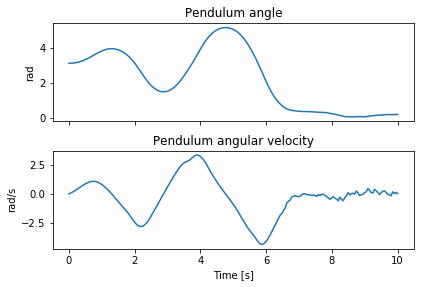

In [19]:
# Plot trajectory
#%matplotlib auto
t = np.linspace(0, n_steps*env.step_size, X.shape[0])
names = ["Pendulum angle", "Pendulum angular velocity"]
units = ["rad", "rad/s"]
fig, axarr = plt.subplots(2, sharex=True)
for i in range(2):
    axarr[i].plot(t, X[:, i])
    axarr[i].title.set_text(names[i])
    axarr[i].set_ylabel(units[i])

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.xlabel('Time [s]')
plt.show()

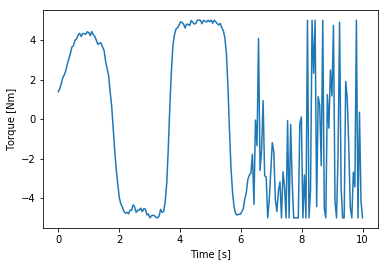

In [20]:
# Plot trajectory
t = np.linspace(0, n_steps*env.step_size, X.shape[0])
plt.figure()
plt.plot(t, U)
plt.ylabel("Torque [Nm]")
plt.xlabel("Time [s]")
plt.show()